In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import argrelextrema, find_peaks
from scipy.io import loadmat
from peakdetect import peakdetect, zero_crossings
import filter as f
import mat73
import os
from scipy.integrate import simps


In [3]:
# STOP REDOWNLOADING THIS
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip

--2020-12-08 03:00:15--  https://archive.ics.uci.edu/ml/machine-learning-databases/00340/data.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3363163675 (3.1G) [application/x-httpd-php]
Saving to: ‘data.zip.2’

data.zip.2            0%[                    ]  18.11M  11.2MB/s               ^C


In [2]:
# STOP RELOADING THIS AS AFTER FIRST
dat = mat73.loadmat(r'data/Part_1.mat')

In [3]:
# Clean Class
# Only detects the systolic peaks and the end of the period. Need to calculate the second derivative of the function in order
# to get to the diastolic peaks and the dicrotic notch
class PT_Detection: 
    
    def __init__(self, data):
        self.data = data
        
    # Detect the systolic/diastolic peaks and the dicrotic notch    
    def detect(self):
        max, min = peakdetect(self.data, np.arange(0,len(self.data)), lookahead=19)
        xmax = [p[0] for p in max]
        ymax = [p[1] for p in max]
        xmin = [p[0] for p in min]
        ymin = [p[1] for p in min]
        
        # Need to perform some checks on the data to make sure that that the data starts with a minimum and ends with a minimum.
        if xmax[0] < xmin[0]:
            xmax = xmax[1:]
            ymax = ymax[1:]
        if xmax[-1] > xmin[-1]:
            xmax = xmax[:-1]
            ymax = ymax[:-1]
        
        return xmax, ymax, xmin, ymin
        
    def display(self, xmax, ymax, xmin, ymin):
        plt.scatter(xmax,ymax, color='red')
        plt.scatter(xmin,ymin, color='yellow')
        plt.plot(self.data)


In [4]:
# Clean Feature Class
class Features:
    def __init__(self, data):
        self.data = data
        extrema = PT_Detection(data)
        self.xmax, self.ymax, self.xmin, self.ymin = extrema.detect()
        self.Avg = np.array([])
        # Set up the indices to match up properly
        if len(self.xmax) > len(self.xmin):
            self.xmax = self.xmax[:-1]
            self.ymax = self.ymax[:-1]
        
    def p2p(self):
        return np.diff(xmax)
    
    def p_i(self):
        return np.diff(xmin)
    
    def SA(self):
        SA = np.array([])
        for max in range(0,len(self.ymax)):
            difference = self.ymax[max] - self.ymin[max]
            SA = np.append(SA, difference)
        return SA
    
    def pwidth(self): # PULSE WIDTH
        PW1 = np.array([])
        PW2 = np.array([])
        PW1x = np.array([])
        PW2x = np.array([])
        PW = np.array([])
        
        self.Avg = np.array([])
        for avg in range(len(self.ymax-1)):
            average = (self.ymax[max] + self.ymin[max]) / 2
            self.Avg = np.append(Avg, average)
            
        i, xval1, xval2 = 0, 0, 0
        for mid in self.Avg: # for each systolic amplitude -> for each PPG wavelength that there is
            u_candidate = np.array([]) # candidates on the way up to the systolic peak
            d_candidate = np.array([]) # candidates on the way down to the end of the wavelength
            height = mid # Want 50% pulse width
            if i >= len(xmin)-1:
                break

            for value in range(self.xmin[i], self.xmax[i+1]):
                u_candidate = np.append(u_candidate, abs((self.data[value] - height)))

            yval1 = self.data[self.xmin[i] + np.argmin(u_candidate)]
            xval1 = self.xmin[i] + np.argmin(u_candidate)
            PW1x = np.append(PW1x, xval1)
            PW1 = np.append(PW1, yval1)
            PW = np.append(PW, xval1)

            for value in range(self.xmax[i+1], self.xmin[i+1]):
                d_candidate = np.append(d_candidate, abs((self.data[value] - height)))
            yval2 = self.data[self.xmax[i+1] + np.argmin(d_candidate)]
            xval2 = self.xmax[i+1] + np.argmin(d_candidate)
            PW2 = np.append(PW2, yval2)
            PW2x = np.append(PW2x, xval2)
            PW = np.append(PW, xval2)
            i += 1
        return np.diff(PW)
        
    def dicrotic(self):
        # First derivative
        dy = np.diff(self.data)
        # Second derivative
        dyy = np.diff(dy)
        zero_x = np.array([])
        zero_y = np.array([])
        i, xval1, xval2 = 0, 0, 0
        for mid in self.xmax: # for each systolic amplitude -> for each PPG wavelength that there is
            candidate = np.array([]) # candidates on the way down to the end of the wavelength
            if i >= len(self.xmin)-1:
                break
    
            interval = range(self.xmax[i], self.xmin[i+1])
            ninterval = interval[int(len(interval)*0.2):int(len(interval)*0.75)]
            for value in ninterval:
                candidate = np.append(candidate, dyy[value])

            xval1 = xmax[i] + np.argmax(candidate)
            zero_x = np.append(zero_x, xval1)
            zero_y = np.append(zero_y, self.data[xval1])

            i += 1
        return zero_x, zero_y
    
    def diastolic(self):
        # First Derivative
        dy = np.diff(self.data)
        # Second Derivative 
        dyy = np.diff(dy)
        
        min_x = np.array([])
        min_y = np.array([])
        i, xval1, xval2 = 0, 0, 0
        for mid in self.xmax: # for each systolic amplitude -> for each PPG wavelength that there is
            candidate = np.array([]) # candidates on the way down to the end of the wavelength
            if i >= len(self.xmin)-1:
                break
    
            interval = range(self.xmax[i], self.xmin[i+1])
            ninterval = interval[int(len(interval)*0):int(len(interval)*0.75)]
            for value in ninterval:
                candidate = np.append(candidate, dyy[value])

            max_ = int(self.xmax[i] + np.argmax(candidate)) # index of the max
            ninterval = range(max_, self.xmin[i+1])
            ninterval_ = ninterval[int(len(ninterval)*0):int(len(ninterval)*0.4)]
            for value in ninterval_:
                candidate = np.append(candidate, dyy[value])
    
            min_ = zero_x[i].astype(int) + np.argmin(candidate)
            min_x = np.append(min_x, min_)
            min_y = np.append(min_y, self.data[min_])
            i += 1
        
    def IPA(self):
        # IPA Extraction
        count1 = 0
        IPA = np.array([])
        for mid in self.Avg:
            if count1 >= len(self.xmin)-1:
                break
        
            between1 = range(self.xmin[count1], self.xmax[count1])
            between2 = range(self.xmax[count1], self.xmin[count1+1])
    
            area1 = simps(between1)
            area2 = simps(between2)
    
    
            ppgratio = area2 / area1
            IPA = np.append(IPA, ppgratio)
            count1 += 1
        return IPA

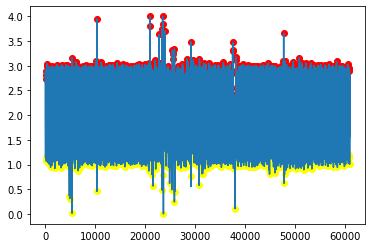

In [5]:
# Load the PPG data
ppg = dat['Part_1'][0][0][29:]

peaks = PT_Detection(ppg)
xmax, ymax, xmin, ymin = peaks.detect() # peaks and troughs of the PPG signal
peaks.display(xmax, ymax, xmin, ymin)


values = Features(ppg)


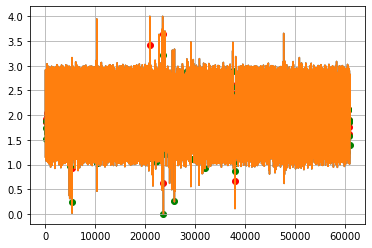

In [6]:

if len(xmax) > len(xmin):
    xmax = xmax[:-1]
    ymax = ymax[:-1]

# Peak to Peak
p2p = np.diff(xmax)

# Pulse Interval
PI = np.diff(xmin)

# Systolic Amplitude
SA = np.array([])
for max in range(len(ymax)):
    difference = ymax[max] - ymin[max]
    SA = np.append(SA, difference)
    
# Average Value between max and min ==> 50% value of the systolic amplitude
Avg = np.array([])
for avg in range(len(ymax)):
    average = (ymax[max] + ymin[max]) / 2
    Avg = np.append(Avg, average)
    


# Pulse Width - at 50% of the systolic amplitude, get the width of the PPG wave from that x value to the next end of the PPG
# wave. 
# 1. Take the systolic amplitude and divide it by 50%, 2. Search through the first half of the PPG wave (before the systolic
# peak) and find the x value that corresponds to that y value of 50% of the systolic amplitude. 3. Search through the second 
# half of the PPG wave and find the x value that corresponds to that same y value. 4. Take the difference in x positions in 
# order to get the 50% pulse width
PW1 = np.array([])
PW2 = np.array([])
PW1x = np.array([])
PW2x = np.array([])
PW = np.array([])
i, xval1, xval2 = 0, 0, 0
for mid in Avg: # for each systolic amplitude -> for each PPG wavelength that there is
    u_candidate = np.array([]) # candidates on the way up to the systolic peak
    d_candidate = np.array([]) # candidates on the way down to the end of the wavelength
    height = mid # Want 50% pulse width
    if i >= len(xmin)-1:
        break

    for value in range(xmin[i], xmax[i]):
        u_candidate = np.append(u_candidate, abs((ppg[value] - height)))

    yval1 = ppg[xmin[i] + np.argmin(u_candidate)]
    xval1 = xmin[i] + np.argmin(u_candidate)
    PW1x = np.append(PW1x, xval1)
    PW1 = np.append(PW1, yval1)
    PW = np.append(PW, xval1)
    for value in range(xmax[i], xmin[i+1]):
        d_candidate = np.append(d_candidate, abs((ppg[value] - height)))
    yval2 = ppg[xmax[i] + np.argmin(d_candidate)]
    xval2 = xmax[i] + np.argmin(d_candidate)
    PW2 = np.append(PW2, yval2)
    PW2x = np.append(PW2x, xval2)
    PW = np.append(PW, xval2)
    
    i += 1
    
t = 0
pulsewidth = np.array([])
for a in range(int(len(PW)/2)):
    diff = PW[t+1] - PW[t]
    pulsewidth = np.append(pulsewidth, diff)
    t += 2
    
    
# First derivative
dy = np.diff(ppg)
# Second derivative
dyy = np.diff(dy)

# so to get the estimate of where the dicrotic notch and the diastolic peak are , you need to be able to find the zero crossing
# of the second derivative where the ppg function is concave up according to the second derivative
# will be checking on if this works for the most part during other max to min's in the second half of the ppg signals
# update: seems to be generally true. Works for the most part

zero_x = np.array([])
zero_y = np.array([])
i, xval1, xval2 = 0, 0, 0
for mid in xmax: # for each systolic amplitude -> for each PPG wavelength that there is
    candidate = np.array([]) # candidates on the way down to the end of the wavelength
    if i >= len(xmin)-1:
        break
    
    interval = range(xmax[i], xmin[i+1])
    ninterval = interval[int(len(interval)*0):int(len(interval)*0.75)]
    for value in ninterval:
        candidate = np.append(candidate, dyy[value])

    xval1 = xmax[i] + np.argmax(candidate)
    zero_x = np.append(zero_x, xval1)
    zero_y = np.append(zero_y, ppg[xval1])

    i += 1
plt.scatter(zero_x,zero_y, color='red')
plt.plot(ppg)
plt.grid(True)

# To separate the diastolic peak and the dicrotic notch, we will look at the second derivative, specifically the interval of
# the max to the mins in the original ppg signal. Inside of this interval, we are going to take the maximum of the first 80% 
# of it and then take from the index of the max to the 80% again of the original 80%. Finally, we will find the minimum of 
# this segment and call it the diastolic peak. If the diastolic peak is inaccurate by being too far in front of the dicrotic
# notch, we can take the first zero crossing and use that as the diastolic peak instead.

min_x = np.array([])
min_y = np.array([])
i, xval1, xval2 = 0, 0, 0
for mid in xmax: # for each systolic amplitude -> for each PPG wavelength that there is
    candidate = np.array([]) # candidates on the way down to the end of the wavelength
    if i >= len(xmin)-1:
        break
    
    interval = range(xmax[i], xmin[i+1])
    ninterval = interval[int(len(interval)*0):int(len(interval)*0.75)]
    for value in ninterval:
        candidate = np.append(candidate, dyy[value])

    max_ = int(xmax[i] + np.argmax(candidate)) # index of the max
    ninterval = range(max_, xmin[i+1])
    ninterval_ = ninterval[int(len(ninterval)*0):int(len(ninterval)*0.4)]
    for value in ninterval_:
        candidate = np.append(candidate, dyy[value])

    #print('candidates:',candidate)
    #print('range:',ninterval_)
    #print('min indexer:',zero_x[i].astype(int))
    #print('min:',np.argmin(candidate))
    #print('max:',np.argmax(candidate))
    
    min_ = zero_x[i].astype(int) + np.argmin(candidate)
    min_x = np.append(min_x, min_)
    min_y = np.append(min_y, ppg[min_])
    i += 1
    
plt.scatter(min_x,min_y, color='green')
plt.plot(ppg)
plt.grid(True)


# IPA Extraction
count1 = 0
IPA = np.array([])
for mid in Avg:
    if count1 >= len(xmax):
        break
        
    between1 = range(xmin[count1], xmax[count1])
    between2 = range(xmax[count1], xmin[count1+1])
    
    area1 = simps(between1)
    area2 = simps(between2)
    
    
    ppgratio = area2 / area1
    IPA = np.append(IPA, ppgratio)
    count1 += 1



In [7]:
np.diff(xmin)

array([ 62,  62,  61,  62,  61,  62,  60,  60,  61,  61,  60,  60,  60,
        60,  61,  60,  60,  60,  61,  61,  61,  60,  60,  62,  61,  60,
        61,  61,  60,  61,  61,  61,  61,  62,  60,  61,  61,  61,  61,
        60,  60,  60,  61,  61,  59,  60,  60,  60,  61,  60,  60,  60,
        61,  61,  61,  60,  62,  61,  62,  61,  60,  62,  61,  62,  60,
        61,  61,  61,  61,  60,  61,  62,  61,  60,  61,  62,  62,  63,
        60,  64,  77,  60,  59,  61,  60,  60,  32,  89,  60,  36,  27,
        61,  62,  61,  62,  63,  62,  61,  61,  62,  61,  62,  61,  61,
        62,  61,  62,  61,  62,  62,  63,  61,  61,  62,  61,  62,  61,
        61,  61,  62,  62,  60,  62,  62,  63,  61,  63,  62,  63,  62,
        62,  62,  63,  62,  62,  61,  62,  62,  62,  61,  61,  62,  61,
        62,  61,  61,  62,  62,  61,  62,  62,  62,  63,  62,  62,  61,
        50,  48,  61,  63,  62,  62,  61,  62,  61,  62,  61,  37,  68,
        79,  62,  61,  61,  62,  61,  62,  61,  62,  62,  62,  6

sdxmin: 1005
sdymin: 1005
sdxmax: 1004
sdymax: 1004
SA: 998
PW: 998
PI: 998
P2P: 998
IPA: 998


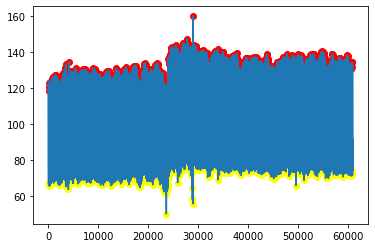

In [8]:
# Need to get the systolic and diastolic blood pressure readings
ABP = dat['Part_1'][0][1]

sdbp = PT_Detection(ABP)
sdxmax, sdymax, sdxmin, sdymin = sdbp.detect() # peaks and troughs of the PPG signal

# Need to perform some checks on the data to make sure that that the data starts with a minimum and ends with a minimum. If 
# this isn't satisfied there are going to be discrepancies with the data to be more realistic for training this needs to be 
# processed first
if sdxmax[0] < sdxmin[0]:
    sdxmax = sdxmax[1:]
    sdymax = sdymax[1:]
if sdxmax[-1] > sdxmin[-1]:
    sdxmax = sdxmax[:-1]
    sdymax = sdymax[:-1]

# Post processing makes it so we need to truncate all of the features except for P2P by 1 row.
SA = SA[:-1]
pulsewidth = pulsewidth[:-1]
PI = PI[:-1]
IPA = IPA[:-1]

sdbp.display(sdxmax,sdymax,sdxmin,sdymin)
    
print('sdxmin:',len(sdxmin))
print('sdymin:',len(sdymin))
print('sdxmax:',len(sdxmax))
print('sdymax:',len(sdymax))

print('SA:',len(SA))
print('PW:',len(pulsewidth))
print('PI:',len(PI))
print('P2P:',len(p2p))
print('IPA:',len(IPA))


In [9]:
print(min_x[0:5])
print(zero_x[0:5])

[ 96. 163. 216. 284. 342.]
[ 93. 155. 216. 278. 340.]


11


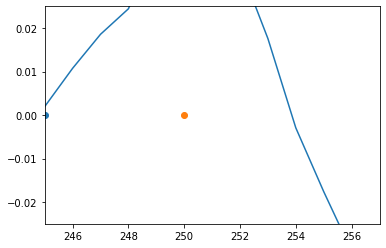

In [10]:
plt.plot(dyy)
plt.xlim(245,257)
plt.scatter(245,0)
plt.scatter(250,0)
plt.ylim(-0.025,0.025)
print(np.argmin(dyy[245:257]))

(-0.1, 0.1)

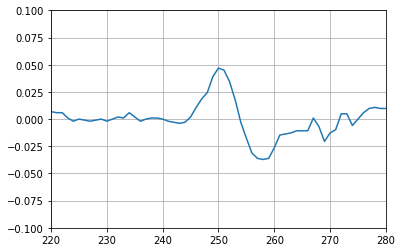

In [11]:
plt.plot(dyy)
plt.xlim(220,280)
plt.grid(True)
plt.ylim(-0.1,0.1)

(0.0, 100.0)

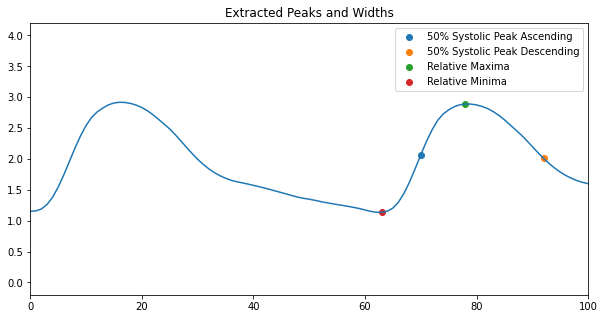

In [12]:
plt.figure(figsize=(10,5))
plt.scatter(PW1x, PW1, label='50% Systolic Peak Ascending')
plt.scatter(PW2x, PW2, label = '50% Systolic Peak Descending')
plt.scatter(xmax,ymax, label = 'Relative Maxima')
plt.scatter(xmin,ymin, label = 'Relative Minima')
plt.title('Extracted Peaks and Widths')
plt.legend()
plt.plot(ppg)
plt.xlim(0,100)

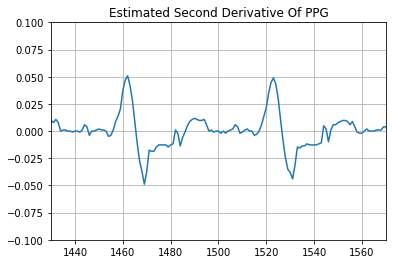

In [13]:
plt.xlim(1430,1570)
plt.ylim(-0.1, 0.1)
plt.title('Estimated Second Derivative Of PPG')
plt.grid(True)
plt.plot(dyy)


(1430.0, 1570.0)

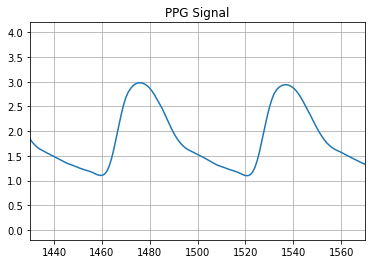

In [14]:
plt.plot(ppg)
plt.title('PPG Signal')
plt.grid(True)
plt.xlim(1430, 1570)

In [15]:
print(len(ppg))

60971


In [16]:
# p2p should have 1 less entry because of the fact that it is in between
# therefore, we need to assign the p2p to the last wave and remove the last entry of all the other waves
print(len(SA))
print(len(pulsewidth))
print(len(PI))
print(len(p2p))
print(len(IPA))

998
998
998
998
998


In [17]:
print(dat['Part_1'][0][1])

[67.06295517 69.35862807 75.36645289 ... 76.44102319 81.81387466
 91.38731909]


(3000.0, 3500.0)

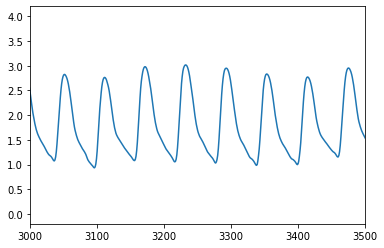

In [18]:
plt.plot(ppg)
plt.xlim(3000,3500)

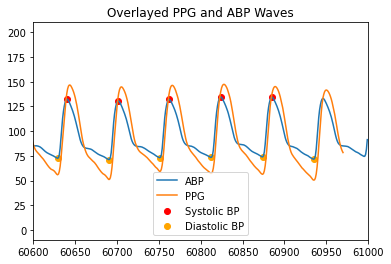

In [19]:
plt.scatter(sdxmax, sdymax, color = 'red', label = 'Systolic BP')
plt.scatter(sdxmin, sdymin, color = 'orange', label = 'Diastolic BP')
plt.xlim(60600,61000)
plt.plot(ABP, label = 'ABP')
plt.plot(ppg*50, label = 'PPG')
plt.title('Overlayed PPG and ABP Waves')
plt.legend()


In [20]:
# remove the first ABP wave -- After loading the PPG signal and the ABP signal, run the next 2 cells once each in order to 
# truncate the arrays to the same length
sdxmax = sdxmax[1:]
sdymax = sdymax[1:]
sdxmin = sdxmin[1:]
sdymin = sdymin[1:]

In [21]:
# Each ppg wave should have its own ABP wave after it to extract the systolic and diastolic blood pressures from. 
# need to remove the first ABP wave because it has a maximum and minimum before the PPG waves even start. Will 
# remove it for the sake of consistency. 

# try syncing the peaks and remove the extras - Truncate the rest of it if you have to to train it
# List of Numpy Arrays that I need to extract into CSV file:
# SA, PW, p2p, PI, sdymax, sdymin

In [22]:
# Export the current feature list into CSV files 
df = pd.DataFrame({'SA': SA, 'PW': pulsewidth, 'PI': PI, 'p2p': p2p, 'IPA': IPA, 'Systolic': sdymax, 'Diastolic': sdymin})
df.to_csv("5features.csv", index=False)

ValueError: arrays must all be same length

In [ ]:
# Export 3000 of the lists from Part_1
export_PPG = np.array([])
export_ABP = np.array([])
for j in range(20):
    export_PPG = np.append(export_PPG, dat['Part_1'][j][0])
    export_ABP = np.append(export_ABP, dat['Part_1'][j][1])
export_PPG = export_PPG.tolist()
export_ABP = export_ABP.tolist()

In [ ]:
# Export the timeseries consisting of just the ABP and PPG signals from UCI's 'Cuff-Less Blood Pressure Estimation Data Set'
ABPPG = pd.DataFrame({'ABP': export_ABP, 'PPG': export_PPG})
ABPPG.to_csv("ABPPG.csv", index = False)

In [ ]:
print('Length of PPG', len(export_PPG))
print('Length of ABP', len(export_ABP))

In [ ]:
type(export_PPG)

In [ ]:
len(export_time)

In [ ]:
plt.plot(export_PPG)
plt.xlim(171500, 172500)

In [ ]:
for j in range(1000):
    export_PPG = np.array([])
    export_ABP = np.array([])

    export_PPG = np.append(export_PPG, dat['Part_1'][j][0])
    export_ABP = np.append(export_ABP, dat['Part_1'][j][1])

    export_PPG = export_PPG.tolist()
    export_ABP = export_ABP.tolist()
    
    # Export the current feature list into CSV files 
    df = pd.DataFrame({'PPG': export_PPG, 'ABP': export_ABP})
    df.to_csv("set" + str(j) + ".csv", index=False)

In [ ]:
plt.plot(ABP)
plt.plot((ppg*50)[29:])
plt.xlim(0,200)

In [ ]:
plt.plot(ppg)

In [ ]:
print(xmin)

In [ ]:
print(sdxmin)

In [35]:
# window is going to be 90 x values because the average PPG wave is around 60-70 
# loop through the current set of PPG signals in order to take a scrolling window and use those windows that are taken as the
# x input into the neural network

'''count = 0
x = np.empty((1,10))
seg_ppg = np.empty((1,1))
x = np.delete(x, 0, 0)
seg_ppg = np.delete(seg_ppg, 0, 0)
for i in range(len(ppg)):
    if count == 9: 
        seg_ppg = seg_ppg.tolist()
        x = np.append(x, seg_ppg, axis = 0)
        seg_ppg = np.empty((1,1))
        seg_ppg = np.delete(seg_ppg, 0, 0)
        count = 0
    else:
        seg_ppg = np.append(seg_ppg, np.array([[ppg[i]]]))
        seg_ppg = np.reshape(seg_ppg, (1, len(seg_ppg)))
    count += 1'''

# Above would probably be useful for when implementing the sliding window but for now going to try just using static
# windows that do not overlap

'count = 0\nx = np.empty((1,10))\nseg_ppg = np.empty((1,1))\nx = np.delete(x, 0, 0)\nseg_ppg = np.delete(seg_ppg, 0, 0)\nfor i in range(len(ppg)):\n    if count == 9: \n        seg_ppg = seg_ppg.tolist()\n        x = np.append(x, seg_ppg, axis = 0)\n        seg_ppg = np.empty((1,1))\n        seg_ppg = np.delete(seg_ppg, 0, 0)\n        count = 0\n    else:\n        seg_ppg = np.append(seg_ppg, np.array([[ppg[i]]]))\n        seg_ppg = np.reshape(seg_ppg, (1, len(seg_ppg)))\n    count += 1'

In [9]:
# trying a reshaping method in order to get the 2d np array that i want
r = len(ppg) % 180 # Trying to take 180 samples but just a test
new = ppg[0:-r]
new = np.reshape(new, (int((len(new)/180)), 180))

In [10]:
len(new)

338

In [11]:
# now need to sync the systolic and diastolic blood pressures by taking the averages of every 90 bit interval
# average the sbp/dbp and then put it into a 1d numpy array to be used as the target variables in the convolution
# neural network

# SBP
check = 1
target = 180
average = 0
count = 0
index = 0
systolic = np.ndarray([])
systolic = np.delete(systolic, 0)
for j in sdxmax:
    if j <= target*check:
        average += sdymax[index]
        count += 1
    else:
        average /= count
        systolic = np.append(systolic, average)
        average = 0
        count = 0
        check += 1
    index += 1
    
# DBP
d_check = 1
d_target = 180
d_average = 0
d_count = 0
d_index = 0
diastolic = np.ndarray([])
diastolic = np.delete(diastolic, 0)
for k in sdxmin:
    if k <= d_target*d_check:
        d_average += sdymin[d_index]
        d_count += 1
    else:
        d_average /= d_count
        diastolic = np.append(diastolic, d_average)
        d_average = 0
        d_count = 0
        d_check += 1
    d_index += 1

In [12]:
len(systolic)

338

In [13]:
len(diastolic)

338

In [17]:
np.save('ppg_windows.npy', new)

In [18]:
np.save('sbp.npy', systolic)
np.save('dbp.npy', diastolic)